1.9 - whats in the notebook
    * calculate tsfeatures & some additional tsforge add ons like CoV, and ADI
    * Plot histograms / KDEs of key diagnostics
        - Trend_strength
        - seasonal_strength
        - entropy
        - ADI/intermittency
    
    Stratify by metadata (department, category)
    
    Metric vs metric scaterplots  (show the diagnostics and the plots - to tie them together)
    
    COMBOS
    trend x adi (when trend lies)
    seasonal strength x adi (when seasonality lies)
    entropy x trend strength
    entop x seasonal strength
    CV2 x ADI



## 1. Setup

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from pathlib import Path
from tsforge import load_m5
import tsforge as tsf
import seaborn as sns

# Configuration
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

Notebook agenda 

* Reconfirm the unique_id definition
* Compute tsfeatures + tsforge diagnostics per unique_id
* Highlight the “Lie Detector Six”

In [7]:
# read in data 
weekly_df = pd.read_parquet(
    "/Users/jackrodenberg/Desktop/real-world-forecasting-foundations/output/1_08_output.parquet"
)

In [8]:
weekly_df.head()

,unique_id,ds,y,item_id,store_id,dept_id,cat_id,state_id,wm_yr_wk,month,year,snap_CA,snap_TX,snap_WI,event_name_1,event_name_2,event_name_3,event_type_1,event_type_2,event_type_3
0,FOODS_1_001_CA_1,2011-01-23,3.0,FOODS_1_001,CA_1,FOODS_1,FOODS,CA,11101,1,2011,0,0,0,None,None,None,None,None,None
1,FOODS_1_001_CA_1,2011-01-30,9.0,FOODS_1_001,CA_1,FOODS_1,FOODS,CA,11101,1,2011,1,1,1,None,None,None,None,None,None
2,FOODS_1_001_CA_1,2011-02-06,7.0,FOODS_1_001,CA_1,FOODS_1,FOODS,CA,11102,2,2011,1,1,1,SuperBowl,None,None,Sporting,None,None
3,FOODS_1_001_CA_1,2011-02-13,8.0,FOODS_1_001,CA_1,FOODS_1,FOODS,CA,11103,2,2011,0,1,1,ValentinesDay,None,None,Cultural,None,None
4,FOODS_1_001_CA_1,2011-02-20,14.0,FOODS_1_001,CA_1,FOODS_1,FOODS,CA,11104,2,2011,0,0,0,PresidentsDay,None,None,National,None,None


In [9]:
weekly_df['unique_id'] = weekly_df['unique_id'].astype(str)

In [10]:
from tsforge.eda.ts_features_extension import permutation_entropy,MI_top_k_lags,ADI
from tsfeatures import tsfeatures,lumpiness,stl_features,statistics
# using nixtla's tsfeatures 
id_lvl_feats = tsfeatures(

    ts = weekly_df,
    # frequency of data is weekly, so here we input 52     
    freq=52,

    # COMPUTE LIE detector six 
    features=[
        statistics,
        lumpiness, # variance of variances 
        permutation_entropy, # permutation entropy 
       # MI_top_k_lags, # sum of MI over top 5 lags 
        stl_features, # STL decomposition Features (Trend, Seasonal Strength)
        ADI, # Avg Demand Interval
      #  pacf_features,
        ],

        scale=False # ENSURE YOU TURN THIS OFF for accurate statistics, otherwise outputs are standard scaled for model training.. 
)

 * Plot histograms / KDEs of key diagnostics
        - Trend_strength
        - seasonal_strength
        - entropy
        - ADI/intermittency
    

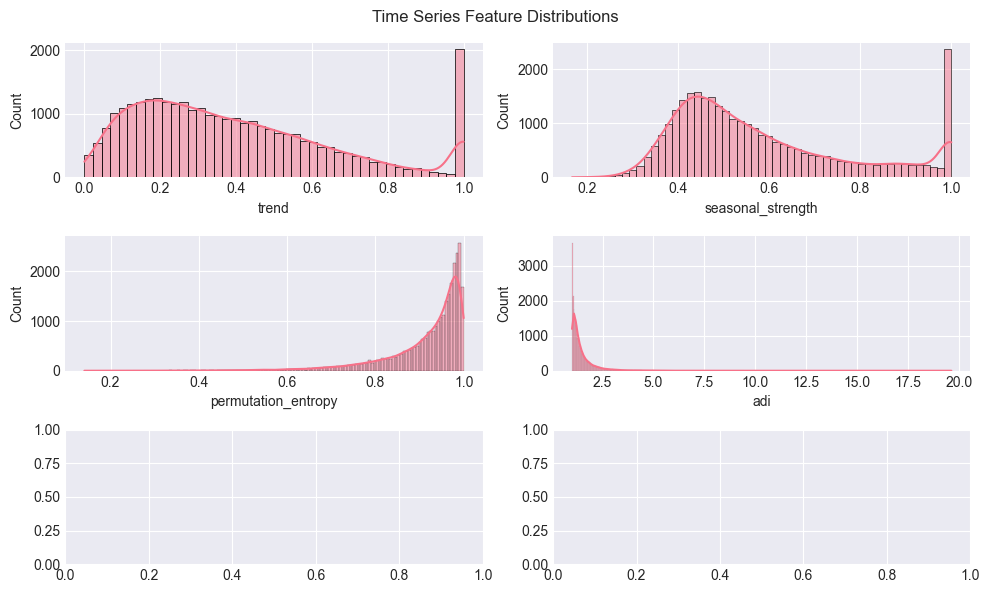

In [12]:
key_inds = ['trend','seasonal_strength','permutation_entropy','adi']

fig, ax = plt.subplots(figsize=(10,6),ncols=2,nrows=3)

ax = ax.flatten()
for ix, ind in enumerate(key_inds):
    sns.histplot(id_lvl_feats[ind],kde=True,ax=ax[ix],label=f"{ind.title()} Distribution (Sku Level)")

fig.suptitle("Time Series Feature Distributions")
fig.tight_layout()

In [ ]:
combo_pairs = [
    ("trend", "adi", "Trend Strength vs. ADI"),
    ("seasonal_strength", "adi", "Seasonal Strength vs. ADI"),
    ("permutation_entropy", "trend", "Entropy vs. Trend Strength"),
    ("permutation_entropy", "seasonal_strength", "Entropy vs. Seasonal Strength"),
]

n_cols = 2
n_rows = int(np.ceil(len(combo_pairs) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
axes = axes.flatten()

for ax, (x_col, y_col, title) in zip(axes, combo_pairs):
    data = id_lvl_feats[[x_col, y_col]].dropna()
    hb = ax.hexbin(
        data[x_col],
        data[y_col],
        gridsize=35,
        cmap="viridis",
        mincnt=1,
    )
    ax.set_title(title)
    ax.set_xlabel(x_col.replace("_", " ").title())
    ax.set_ylabel(y_col.replace("_", " ").title())
    fig.colorbar(hb, ax=ax, label="Count")

# Hide any unused axes
for ax in axes[len(combo_pairs):]:
    ax.axis("off")

fig.suptitle("Metric vs Metric Hexbin Diagnostics", fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.9)


In [ ]:
fig, ax = plt.subplots(figsize=(10, 6), ncols=2, nrows=3)

ax = ax.flatten()
for ix, ind in enumerate(key_inds):
    sns.histplot(
        id_lvl_feats[ind], kde=True, ax=ax[ix], label=f"{ind.title()} Distribution (Sku Level)"
    )

fig.suptitle("Time Series Feature Distributions")
fig.tight_layout()


In [20]:
help(combos)

Help on combinations in module itertools object:

class combinations(builtins.object)
 |  combinations(iterable, r)
 |
 |  Return successive r-length combinations of elements in the iterable.
 |
 |  combinations(range(4), 3) --> (0,1,2), (0,1,3), (0,2,3), (1,2,3)
 |
 |  Methods defined here:
 |
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |
 |  __iter__(self, /)
 |      Implement iter(self).
 |
 |  __next__(self, /)
 |      Implement next(self).
 |
 |  __reduce__(...)
 |      Return state information for pickling.
 |
 |  __setstate__(...)
 |      Set state information for unpickling.
 |
 |  __sizeof__(...)
 |      Returns size in memory, in bytes.
 |
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |
 |  __new__(*args, **kwargs)
 |      Create and return a new object.  See help(type) for accurate signature.



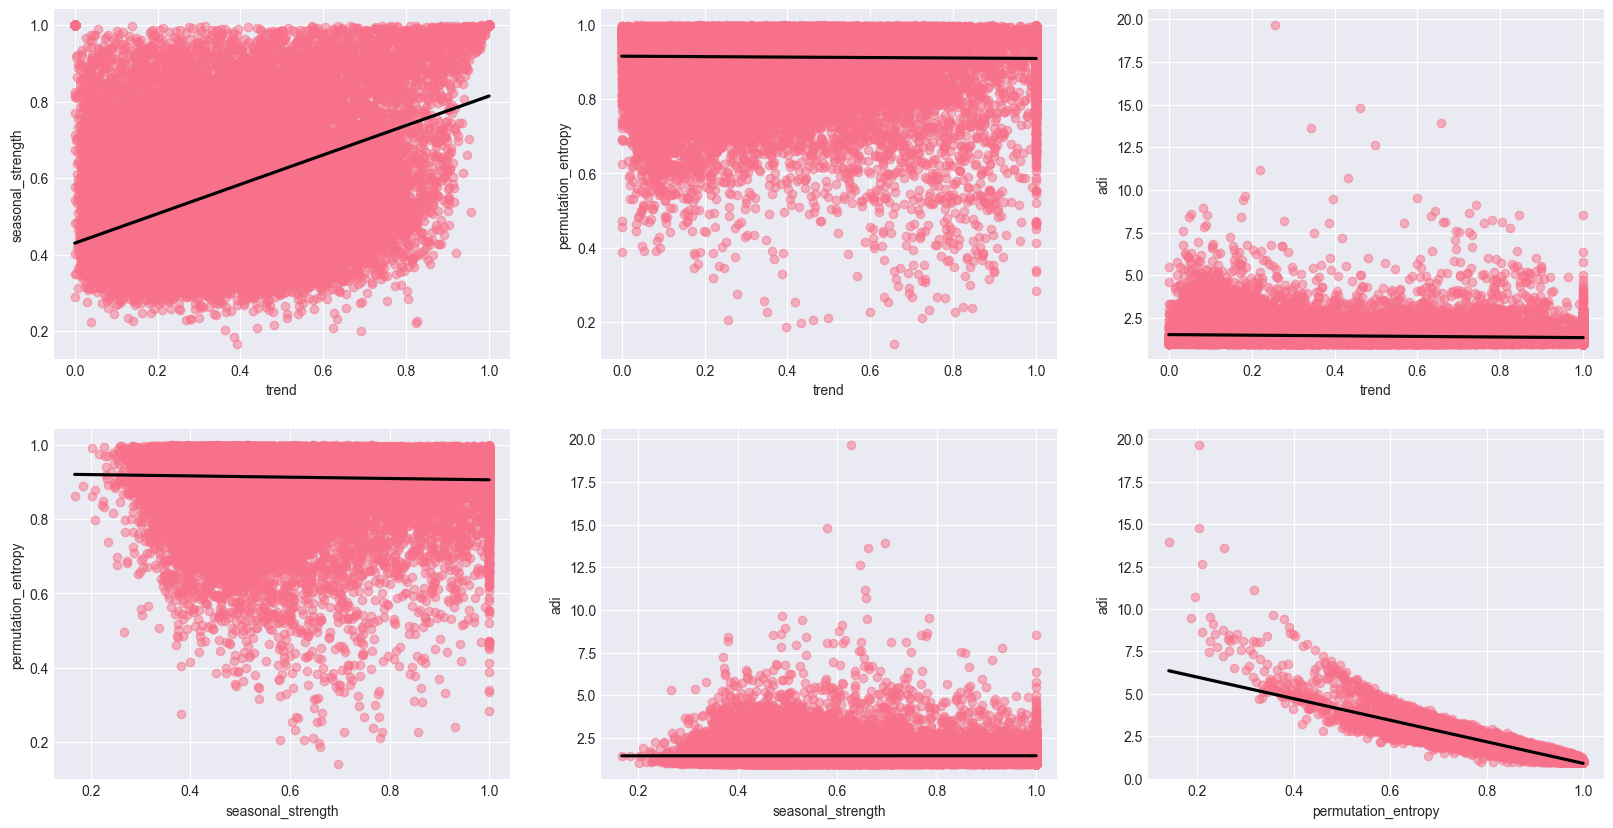

In [ ]:
# trend x adi (when trend lies)
#     seasonal strength x adi (when seasonality lies)
#     entropy x trend strength
#     entop x seasonal strength
#     CV2 x ADI

import itertools 

combos = itertools.combinations(key_inds,2)

fig, ax = plt.subplots(2,3, figsize=(20,10))
ax = ax.flatten()
for ix, combo in enumerate(combos):
    sns.hexbin(
        data = id_lvl_feats,
        x=combo[0],
        y=combo[1],
        ax=ax[ix],
        line_kws={"color": "black","alpha":.3},
        scatter_kws={"alpha": 0.5},
       # robust=True,
 #       edgecolor='black',
      #  alpha=0.5
    )